In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

Use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters.

In [3]:
df = pd.read_csv("./data/2-5-marathon-2014.csv")
df.shape

(31984, 21)

In [4]:
# Remove wheelchair participants — otherwise the race times are all over the map
df["wheelchair"] = df.bib.str.contains("W")
df = df[df.wheelchair == False]

In [6]:
df.sort_values("official").head(10)[["name", "overall", "official", "pace", "5k", "country"]]

,name,overall,official,pace,5k,country
39,"Keflezighi, Meb",1,128.62,4.92,15.15,USA
11,"Chebet, Wilson",2,128.80,4.92,15.18,KEN
20,"Chepkwony, Frankline",3,128.83,4.92,15.18,KEN
50,"Shafar, Vitaliy",4,129.62,4.95,15.40,UKR
7,"Geneti, Markos",5,129.83,4.97,15.17,ETH
32,"Kimurer, Joel",6,131.05,5.00,15.18,KEN
47,"Arciniaga, Nicholas",7,131.78,5.03,15.18,USA
54,"Eggleston, Jeffrey",8,131.95,5.03,15.20,USA
29,"Lonyangata, Paul",9,132.57,5.07,15.18,KEN
26,"Annani, Adil",10,132.72,5.07,15.18,MAR


In [5]:
[print(c) for c in df.columns]

10k
name
division
25k
gender
age
official
bib
genderdiv
ctz
35k
overall
pace
state
30k
5k
half
20k
country
city
40k
wheelchair


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
df.describe()

,division,age,official,genderdiv,overall,pace
count,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000
mean,1935.744073,42.419968,243.223522,8064.377752,15966.000000,9.284285
std,1714.871975,11.314113,52.037284,4746.662139,9217.830059,1.982437
min,1.000000,18.000000,128.620000,1.000000,1.000000,4.920000
25%,614.000000,34.000000,205.680000,3992.000000,7983.500000,7.850000
50%,1428.000000,42.000000,232.430000,7983.000000,15966.000000,8.870000
75%,2614.000000,50.000000,273.325000,11974.500000,23948.500000,10.430000
max,6979.000000,81.000000,538.880000,17575.000000,31931.000000,20.570000


## Columns

- official
- age
- gender
- overall (position in the race)
- country

--

Don't care

- pace
- name
- bib
- genderdiv
- division
- ctz
- state
- city

--

Maybe we care

- 5k
- 10k
- 20k
- half
- 25k
- 30k
- 35k
- 40k

In [7]:
df["male"] = df.gender == "M"

In [8]:
df = df.sort_values("official")[["official", "age", "male", "overall"]]
df.shape

(31931, 4)

In [28]:
X = df.iloc[:,1:]
# X = df.values

# We declare y (to remain consistent with supervised learning) but don't use it
y = df.iloc[:,0]

In [75]:
# Could we use PCA here? Not sure how to interpret the graph below.
X_norm = normalize(X)
X_pca = PCA(2).fit_transform(X_norm)
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_pca)

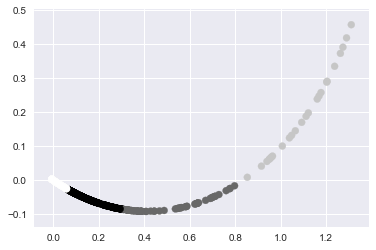

In [76]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, label=y_pred)
plt.show()

In [32]:
# TODO analyze the PCA cluster
K = KMeans(n_clusters=2, random_state=42).fit(X_pca)
K.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [35]:
X["results"] = K.labels_
X.head()

,age,male,overall,results
39,38,True,1,1
11,28,True,2,1
20,29,True,3,1
50,32,True,4,1
7,29,True,5,1


In [38]:
X.groupby("results")[["age", "male", "overall"]].mean()

,age,male,overall
results,,,
0,42.440875,0.549933,15994.998839
1,30.931034,0.810345,30.137931


In [41]:
len(X[X.results == 1])

58

In [ ]:
# Let's compare scores using silhouette_score
from sklearn.metrics import silhouette_score

silhouette_score(X, K.labels_)

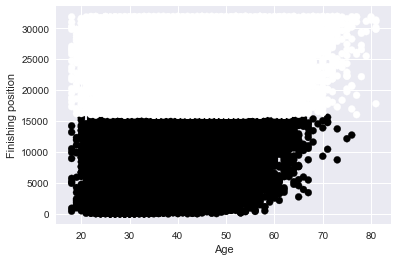

In [58]:
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X)
plt.scatter(X.age, X.overall, c=y_pred)
plt.ylabel('Finishing position')
plt.xlabel('Age')
plt.show()

In [19]:
# Let's try different models: MeanShift
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X.values, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
cluster_centers = ms.cluster_centers_
labels = ms.labels_

n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


In [20]:
X.shape

(31931, 3)

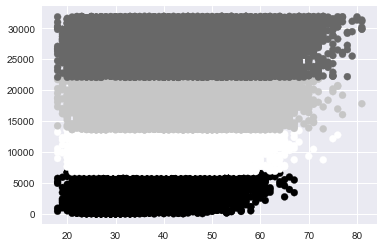

In [21]:
plt.scatter(X.age, X.overall, c=labels)
plt.show()

In [64]:
np.bincount(labels)

array([6783, 8480, 9884, 6784])

In [65]:
X["meanshift"] = labels

In [66]:
X.groupby("meanshift")[["age", "male", "overall"]].mean()

,age,male,overall
meanshift,,,
0,41.667846,0.516291,10176.0
1,45.014387,0.432075,17807.5
2,43.884359,0.472885,26989.5
3,37.795401,0.845371,3392.5


In [22]:
# # Time for Spectral Clustering
# # Note: This is slow
# from sklearn.cluster import SpectralClustering

# # Let's use 4 clusters since that's what we estimated above
# n_clusters=4
# sc = SpectralClustering(n_clusters=n_clusters)
# sc.fit(X)
# predict=sc.fit_predict(X)

# plt.scatter(X.age, X.overall, c=predict)
# plt.show()

In [23]:
# Question: How do you pick which values to use when graphing the plots? (On the X and Y axis)
# Question: Would it make sense to use PCA here? See the resulting graph above.
# Question: How is this useful in real life? As in, how do we know how the different models are clustering?
####: If I was looking to group user based engagement and I calculated that there are our users fall into 1 of 4 groups.
####: How do you know what criteria is used for these groups?